<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Building Models for Accuracy vs. Speed

This notebook analyses how various parameters influence model accuracy and inference speed. For evaluation, the popular [**COCO**](http://cocodataset.org/#home) dataset is used to better compare our numbers with publised results. In particular, we show that we are able to reproduce the accuracy of the pre-trained Faster R-CNN model reported on Torchvision's [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

Familiarity with the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook is assumed, and hence no explanation for repeated concepts or code provided. Instead, we focus on new aspects such as how to improve speed or accuracy. Training a new model on the COCO dataset, while not covered in this notebook, could be easily added by copying the respective cells from the 01_training_introduction notebook.



## Initialization

Import all the functions we need.

In [16]:
import sys

sys.path.append("../../")

import os
import time
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torchvision

from utils_cv.common.data import unzip_url #, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset #, get_transform
from utils_cv.detection.plot import plot_pr_curves
from utils_cv.detection.model import (
    DetectionLearner,
    get_pretrained_fasterrcnn,
)
from utils_cv.common.gpu import which_processor, is_windows
from utils_cv.detection.data import coco_labels

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
Torch is using GPU: Tesla V100-PCIE-16GB


In [17]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Make sure a GPU is present, since accuracy computation in detector.evaluate() has a hard constraint on it.

In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")
assert device.type == 'cuda'

Using torch device: cuda


---

# Prepare COCO Dataset

#### Download data

The COCO 2017 validation dataset is used in all our experiments following common practice for benchmarking object detection models. In particular, two files need to be downloaded from [http://cocodataset.org](http://cocodataset.org/#download): the actual images [2017 val images (1GB)](http://images.cocodataset.org/zips/val2017.zip) and the ground truth annotations [2017 train/val annotations (241MB)](http://images.cocodataset.org/annotations/annotations_trainval2017.zip).

These files should then be placed in a root-folder as shown below, with subfolders called *annotationsCOCO* and *images*:
```
/coco2017
+-- annotationsCOCO
|   +-- captions_train2017.json
|   +-- captions_val2017.json
|   +-- ...
+-- images
|   +-- 000000000139.jpg
|   +-- 000000000285.jpg
|   +-- ...
```


#### Convert COCO to VOC

Next, we need to convert the downloaded annotations from COCO format to Pascal VOC format in order to run this notebook. The function coco2voc does exactly that and only takes seconds to run. In the code below, we assume the COCO images and annotations are in the folder '/data/coco2017/'; the function then creates a new sub-directory called *annotations*. The function also if needed downloads the images provided their urls are specified in the annotation `.json` file.


```python
from utils_cv.detection.data import coco2voc
coco2voc(
    anno_path  = "/data/coco2017/annotationsCOCO/instances_val2017.json",
    output_dir = "/data/coco2017/",
    download_images = False
)
```

# Load Images

The line below sets the path to the data and should point to the coco2017 root directory. To be able to run this notebook 
even without having to download COCO we use by default below our fridge object dataset from the [01_training_introduction](01_training_introduction.ipynb) notebook.

In [6]:
#DATA_PATH = "/data/coco2017/"
#DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)



DATA_PATH = r"C:\Users\pabuehle\Desktop\coco_val2017"





In [7]:
# Verify the directory (when using COCO) contains the annotations, images, and (albeit not used) the annotationsCOCO folders.
path = Path(DATA_PATH)
os.listdir(path)

['annotations', 'annotationsCOCO', 'images']

Most of the code in this notebook is identical to the [01_training_introduction](01_training_introduction.ipynb) notebook. The main change is due to having to ensure that the label names and order of labels in the `DetectionDataset` object matches the labels and label order of the pre-trained model. Hence we explicitley provide the `labels` as input to the `DetectionDataset`. In particular:
- the `[1:]` below because the first element of the coco_labels() array is '__background__'. 
- we set `allow_negatives = True` since a few of the COCO images don't contain any of the COCO objects and hence don't have a correspoding `.xml` annotation file.
- For similarity with the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook and since the `DetectionDataset` assumes a non-empty training set, we addign one of the 5000 images to the training set (which will never be used). 

In [8]:
labels = coco_labels()[1:]
data = DetectionDataset(DATA_PATH, train_pct=0.0001, labels = labels, allow_negatives = True)
print(f"Number of test images: {len(data.test_ds)}")

Number of test images: 4999


And some more detailed information, ie. the counts of ground truth boxes per class, as well as the distribution of absolute and relative widths/heights of the annotations. 

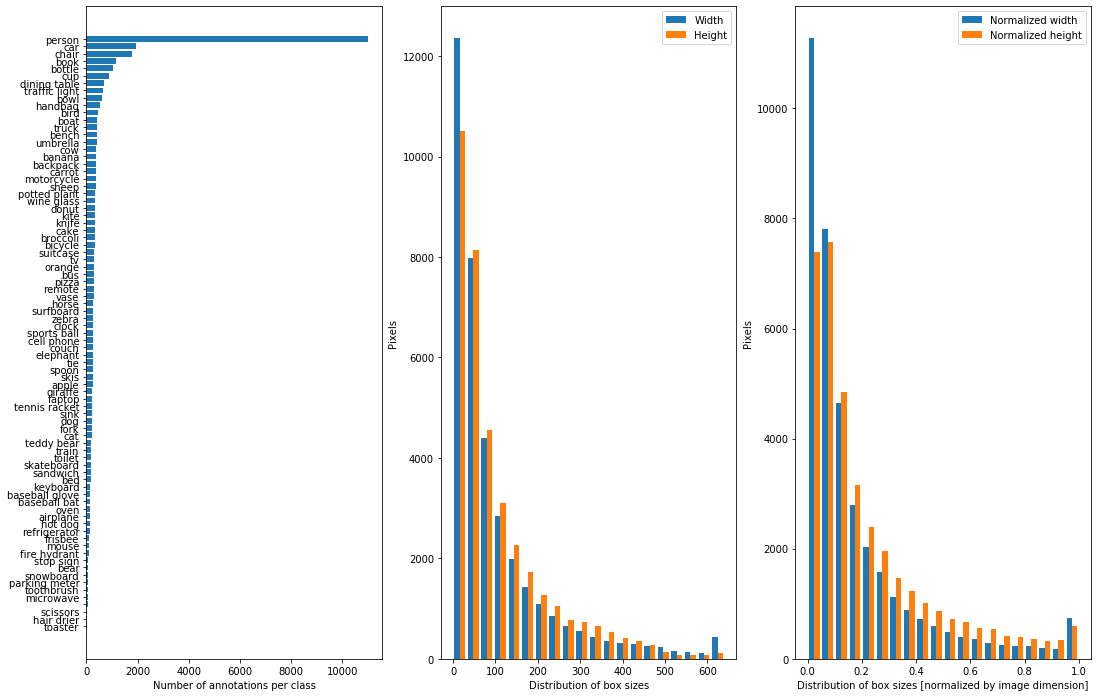

In [9]:
data.plot_boxes_stats(figsize = (18,12))

Lets visualize the annotations to make sure they look correct.

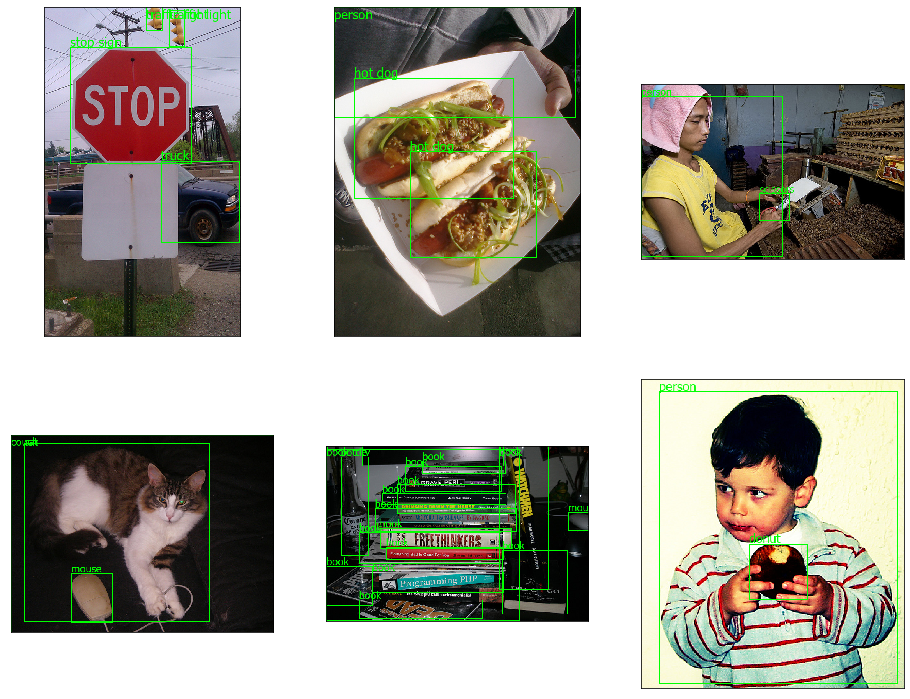

In [10]:
data.show_ims(rows=2)

# Reproduce reported accuracy

The cell below loads the Faster-RCNN model (with FPN) which was trained on COCO. In contrast to the [01_training_introduction.ipynb](01_training_introduction.ipynb) notebook, we want to keep the last layer of the pre-trained model using the function `get_pretrained_fasterrcnn()`.

In [11]:
model = get_pretrained_fasterrcnn()
detector = DetectionLearner(data, model)
print(f"Model: {type(detector.model)}")

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


We can simply run the `evaluate()` method and observe that the mAP in the first row (for IoU=0.50:0.95) is close to the mAP of 37.0 reported on Torchvision's [models](https://pytorch.org/docs/stable/torchvision/models.html) site.

In [12]:
e = detector.evaluate()

creating index...
index created!
Test:  [   0/2500]  eta: 9:06:25  model_time: 13.0521 (13.0521)  evaluator_time: 0.0152 (0.0152)  time: 13.1142  data: 0.0469  max mem: 857
Test:  [ 100/2500]  eta: 0:10:28  model_time: 0.0781 (0.2206)  evaluator_time: 0.0156 (0.0161)  time: 0.1282  data: 0.0219  max mem: 1683
Test:  [ 200/2500]  eta: 0:07:30  model_time: 0.0937 (0.1550)  evaluator_time: 0.0156 (0.0158)  time: 0.1306  data: 0.0266  max mem: 1683
Test:  [ 300/2500]  eta: 0:06:23  model_time: 0.0781 (0.1328)  evaluator_time: 0.0156 (0.0168)  time: 0.1306  data: 0.0273  max mem: 1799
Test:  [ 400/2500]  eta: 0:05:42  model_time: 0.0781 (0.1215)  evaluator_time: 0.0156 (0.0167)  time: 0.1290  data: 0.0258  max mem: 1799
Test:  [ 500/2500]  eta: 0:05:12  model_time: 0.0781 (0.1144)  evaluator_time: 0.0156 (0.0171)  time: 0.1291  data: 0.0243  max mem: 1799
Test:  [ 600/2500]  eta: 0:04:48  model_time: 0.0781 (0.1098)  evaluator_time: 0.0156 (0.0169)  time: 0.1267  data: 0.0281  max mem: 1799

In addition to the mAP numers, we also plot respective recision-recall curves

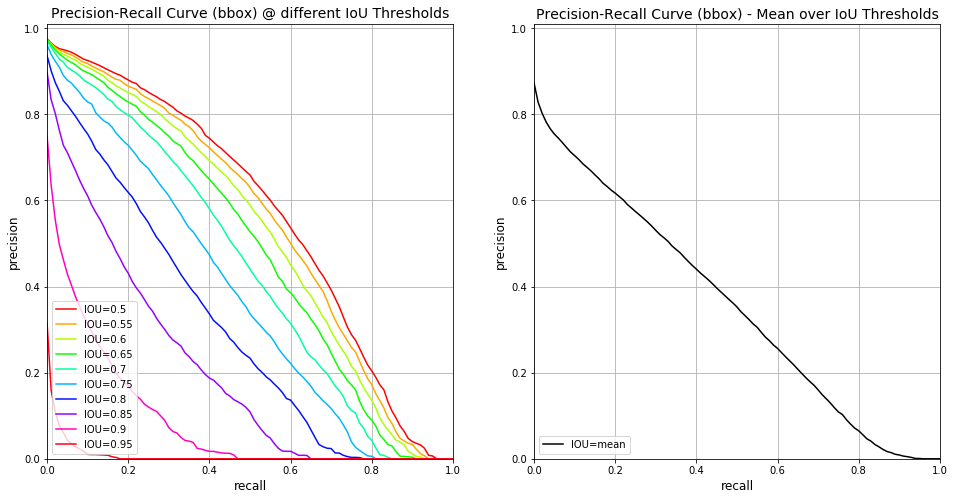

In [13]:
plot_pr_curves(e)

# Inference speed versus accuracy

**THIS SECTION WILL BE ADDED SOON**.

# Conclusion

This notebook showed how to evaluate torchvision's pre-trained Faster R-CNN model on the COCO dataset to re-produce the published accuracy.